# Zembo Geographic City expansion Gurobi Optimisation
## By Felix VEAUX

There are "Franchise (cabinets)", "Internal Grid", "Internal Hybrid".

The following constraints were enforced:
1.	Maximum Swap Stations: 
a.	30 Internal Hybrid
b.	20 Internal Grid
c.	20 franchise cabinets
2.	5 stations (All type combined) per chosen city
3.	1 station every 30 kilometers
4.	All Franchise cabinets must be placed
5.	Franchise cabinets are placed in cities themselves with population greater than average.
6.	Each city that can have must have at least 1 franchise.
7.	At least 1 hybrid in each route 
8.	Swap station placement order of priority:
a.	First, place a franchise cabinet in the city if possible
b.	Second, place hybrid on road 
c.	Third, place the grid station for the rest





# Optimization Model Constraints and Placement Logic (Optimisation Setup)

### Decision Variables
Let:
- $F_i$ denote the number of Franchise cabinets placed in city $i$.
- $H_j$ denote the number of Internal Hybrid stations placed on road segment $j$.
- $G_k$ denote the number of Internal Grid stations placed in city or on road segment $k$.


- Population of each city: $\text{Pop}_i$
- Average city population: $\text{Pop}_{\text{avg}}$


1. **Total Number of Cabinets**:
   - $\sum_i F_i = 20$ (All Franchise cabinets must be placed in cities).
   - $\sum_j H_j \leq 30$ (Limit on Hybrid stations).
   - $\sum_k G_k \leq 20$ (Limit on Grid stations).

### Objective Function

The objective function maximizes the population covered by selected cities while minimizing the number of Franchise, Hybrid, and Grid stations used.

$$
\text{exp} = \sum_{i=1}^{\text{Num\_Cities}} x_i \cdot \text{Population}_i - \sum_{i=1}^{\text{Num\_Cities}} (y_{\text{grid},i} + y_{\text{hybrid},i} + y_{\text{franchise},i})
$$



### Parameters
- Maximum Franchise cabinets: $20$
- Maximum Internal Hybrid stations: $30$
- Maximum Internal Grid stations: $20$


### Constraints (Station Placements)

2. **Franchise Cabinets in Cities**:
   - Franchise cabinets must be placed only in cities with populations greater than the average:
     $$
     F_i \geq 1 \quad \text{if } \text{Pop}_i > \text{Pop}_{\text{avg}}
     $$
   - Each city that can accommodate a Franchise cabinet must have at least one:
     $$
     F_i \geq 1 \quad \forall i
     $$

3. **Internal Hybrid and Grid Priority**:
   - Place "Hybrid" stations on road segments as a priority:
     $$
     H_j \geq 1 \quad \forall j
     $$
   - Place "Grid" stations for remaining segments where "Hybrid" placement isn’t feasible.

4. **City-Specific Priority**:
   - Franchise cabinets take priority in each city, but there must be at least one other cabinet type (Hybrid or Grid) in any city where a Franchise cabinet is placed:
     $$
     F_i \geq 1 \Rightarrow (H_i + G_i \geq 1) \quad \forall i
     $$

5. **Hybrid Requirement on Each Route**:
   - Each route must have at least one Hybrid station:
     $$
     H_j \geq 1 \quad \forall j \text{ (each route segment)}
     $$

### Placement Logic

1. **Step 1**: Place Franchise cabinets in cities with populations greater than $\text{Pop}_{\text{avg}}$ where possible.

2. **Step 2**: Prioritize placement of Internal Hybrid stations on road segments as long as the maximum of 30 is not exceeded.

3. **Step 3**: For remaining requirements, place Internal Grid stations in cities or road segments, respecting the maximum of 20.

This setup ensures that all Franchise cabinets are utilized, Hybrid stations are prioritized on roads, and cities have a balanced distribution of cabinet types.


### Constraints (Geographic Expansion)

1. **Maximum Number of Cities**: The total number of selected cities must not exceed the specified maximum, ${\text{Max\_Cities}}.$
   $$
   \sum_{i=1}^{\text{Num\_Cities}} x_i \leq \text{Max\_Cities}
   $$

2. **Total Franchise Cabinets**: Ensure exactly  ${\text{Max\_Franchise} }$ Franchise cabinets are placed.
   $$
   \sum_{i=1}^{\text{Num\_Cities}} y_{\text{franchise},i} = \text{Max\_Franchise}
   $$

3. **Maximum Grid and Hybrid Stations**: Ensure the total Grid and Hybrid stations do not exceed their respective maximums.
   $$
   \sum_{i=1}^{\text{Num\_Cities}} y_{\text{grid},i} \leq \text{Max\_Grid}
   $$
   $$
   \sum_{i=1}^{\text{Num\_Cities}} y_{\text{hybrid},i} \leq \text{Max\_Hybrid}
   $$

4. **Kampala Selection**: Kampala (index \( i = 0 \)) is always included in the network.
   $$
   x_0 \geq 1
   $$

5. **Limit Franchise Cabinets per City**: The number of Franchise cabinets in any city is limited to \( \text{Max\_Franchise\_Per\_City} \).
   $$
   y_{\text{franchise},i} \leq \text{Max\_Franchise\_Per\_City} \quad \forall i
   $$

6. **City Selection Dependency**: If a city \( i \) is selected, then the previous city on the route (indexed by \( \text{PreviousID}[i] \)) must also be selected.
   $$
   x_i \leq x_{\text{PreviousID}[i]}
   $$

7. **Hybrid and Total Station Requirements**:
   - **Hybrid Minimum**: Each route must include at least one Hybrid station if the route is selected.
     $$
     y_{\text{hybrid},i} \geq x_i
     $$

- **Total Stations per City**: Ensure that the total number of Franchise, Hybrid, and Grid stations in each city meets the minimum required. This minimum is calculated as:

  $$
  \text{required\_stations}_i = \lceil \text{stpercity} + \frac{\text{Distance}[i]}{\text{stperkm}} \rceil
  $$

  Then, for each city \( i \), we ensure:

  $$
  y_{\text{hybrid},i} + y_{\text{grid},i} + y_{\text{franchise},i} \geq \text{required\_stations}_i \cdot x_i
  $$

where:

- $ \text{stpercity} $ is the base number of stations required per city,
- $ \text{Distance}[i] $ is the distance to the previous city,
- $ \text{stperkm} $ is the number of stations needed per kilometer,
- $ x_i $ is a binary variable indicating whether city $ i $ is selected.



## Gurobi Optimisation


In [2]:
import gurobipy as gb
from gurobipy import GRB, quicksum
import pandas as pd
import math

# Load the data
df_uploaded = pd.read_csv("C:/Users/felix/OneDrive/McGill Master Work/4 - Case Competition/Zembo/Round 3/oPTIMISATION ROUND 3/Data Uganda Optimisation - FelixV2.csv")

# Define data
City = df_uploaded['City'].tolist()
Population = df_uploaded['Population'].tolist()
Distance = df_uploaded['Dist from previous'].tolist()
Route_Color = df_uploaded['Route Color'].tolist()
ID = df_uploaded['ID'].tolist()
PreviousID = df_uploaded['Previous ID'].tolist()

Max_Cities = 50  # Max cities excluding Kampala
Max_Franchise = 20  # Max Franchise cabinets
Max_Hybrid = 30 - 10  # Max Internal Hybrid stations
Max_Grid = 20  # Max Internal Grid stations

stpercity = 5  # Number of stations per city
Max_Franchise_Per_City = stpercity - 1  # Maximum number of franchise cabinets per city
stperkm = 30   # Number of stations per x km

Max_Grid_Per_City = 5  # Example value
Max_Hybrid_Per_City = 3  # Example value



Num_Cities = len(City)

# Calculate average population for franchise cabinet placement
avg_population = sum(Population) / Num_Cities

# Create a dictionary to map each city ID to its index in the variables
id_to_index = {ID[i]: i for i in range(Num_Cities)}

# Create a new model
model = gb.Model("City_Expansion")
model.setParam('MIPGap', 0.00001)
model.Params.OutputFlag = 0

# Binary variables for city selection
x = model.addVars(Num_Cities, lb=0, ub=1, vtype=GRB.BINARY, name=[City[i] for i in range(Num_Cities)])

# Define variables for the three types of stations, making y_franchise an integer
y_franchise = model.addVars(Num_Cities, lb=0, ub=Max_Franchise_Per_City, vtype=GRB.INTEGER, name=[f"Franchise_{City[i]}" for i in range(Num_Cities)])
y_grid = model.addVars(Num_Cities, lb=0, ub=Max_Grid_Per_City, vtype=GRB.INTEGER, name=[f"Grid_{City[i]}" for i in range(Num_Cities)])
y_hybrid = model.addVars(Num_Cities, lb=0, ub=Max_Hybrid_Per_City, vtype=GRB.INTEGER, name=[f"Hybrid_{City[i]}" for i in range(Num_Cities)])

# Objective function: Maximize population covered while minimizing stations
exp = quicksum(x[i] * Population[i] for i in range(1, Num_Cities)) - quicksum(y_grid[i] + y_hybrid[i] + y_franchise[i] for i in range(1, Num_Cities))
model.setObjective(exp, GRB.MAXIMIZE)



# Constraints
model.addConstr(quicksum(x[i] for i in range(1, Num_Cities)) <= Max_Cities, name="Max_Cities_constraint")
model.addConstr(quicksum(y_franchise[i] for i in range(Num_Cities)) == Max_Franchise, name="Total_Franchise_Placed")  # Ensure exact total franchise cabinets are placed
model.addConstr(quicksum(y_grid[i] for i in range(Num_Cities)) <= Max_Grid, name="Max_Grid_constraint")
model.addConstr(quicksum(y_hybrid[i] for i in range(Num_Cities)) <= Max_Hybrid, name="Max_Hybrid_constraint")
model.addConstr(x[0] >= 1, name="Kampala_Selection_constraint")  # Ensure Kampala is always selected

# Limit the maximum number of franchise cabinets per city
for i in range(Num_Cities):
    model.addConstr(y_franchise[i] <= Max_Franchise_Per_City, name=f"Max_Franchise_Per_City_{City[i]}")

# City selection dependency: If a city is chosen, its previous city must also be chosen
for i in range(Num_Cities):
    if not pd.isna(PreviousID[i]) and PreviousID[i] in id_to_index:
        prev_id_index = id_to_index[PreviousID[i]]
        model.addConstr(x[i] <= x[prev_id_index], name=f"City_Selection_Dependency_{City[i]}")

for i in range(1, Num_Cities):
    distance = Distance[i]
    required_stations = math.ceil(stpercity + distance / stperkm)

    # Prioritize Franchise cabinets in cities with population above average without enforcing
    model.addConstr(y_franchise[i] <= x[i] * Max_Franchise_Per_City, name=f"Franchise_Placement_{City[i]}")
    

    # Ensure each route has at least one Hybrid station if possible
    model.addConstr(y_hybrid[i] >= x[i], name=f"Hybrid_Minimum_{City[i]}")

    # Total stations required per city
    model.addConstr(y_hybrid[i] + y_grid[i] + y_franchise[i] >= required_stations * x[i], name=f"Total_Stations_{City[i]}")


# Solve the model
model.optimize()

# Output results
if model.status == GRB.OPTIMAL:
    total_franchise = sum(y_franchise[i].x for i in range(Num_Cities))
    total_grid = sum(y_grid[i].x for i in range(Num_Cities))
    total_hybrid = sum(y_hybrid[i].x for i in range(Num_Cities))
    total_cities_chosen = sum(x[i].x for i in range(1, Num_Cities))
    total_population = sum(x[i].x * Population[i] for i in range(1, Num_Cities))
    total_distance = sum(x[i].x * Distance[i] for i in range(1, Num_Cities))
    print("-" * 50)
    print("--- Zembo New City Route Options Planning Gurobi Optimization: ---")
    print("       The Parameters are:")
    print(f"The Maximum number of cities is: {Max_Cities}")
    print(f"Maximum Franchise Cabinets: {Max_Franchise}, Internal Grid: {Max_Grid}, Internal Hybrid: {Max_Hybrid}\n")
    print("-" * 50)
    # Print total summary
    print("      The New Zembo Market is:")
    print(f"Total Franchise cabinets placed: {total_franchise}")
    print(f"Total Internal Grid stations placed: {total_grid}")
    print(f"Total Internal Hybrid stations placed: {total_hybrid}")
    print(f"Total cities chosen are: {total_cities_chosen}")
    print(f"Total population reached is: {total_population}")
    print(f"The total distance travelled is: {total_distance}")
    print("-" * 50 + "\n")
    # Print details for each city
    print("    The New cities to be covered by Zembo are:")

    cities = []
    for i in range(1, Num_Cities):  # Start from 1 to exclude Kampala
        if x[i].x > 0.5:  # City is selected if x[i] > 0
            city = City[i]
            route = Route_Color[i]
            population_touched = Population[i]
            print(f"{city} - on route - {route} - was selected."f"Population reached: {population_touched}"f" Franchise: {y_franchise[i].x}, Grid: {y_grid[i].x}, Hybrid: {y_hybrid[i].x}")
            cities.append(city)   
else:
    print("No optimal solution found.")


Set parameter MIPGap to value 1e-05
--------------------------------------------------
--- Zembo New City Route Options Planning Gurobi Optimization: ---
       The Parameters are:
The Maximum number of cities is: 50
Maximum Franchise Cabinets: 20, Internal Grid: 20, Internal Hybrid: 20

--------------------------------------------------
      The New Zembo Market is:
Total Franchise cabinets placed: 20.0
Total Internal Grid stations placed: 17.0
Total Internal Hybrid stations placed: 20.0
Total cities chosen are: 8.0
Total population reached is: 877343.0
The total distance travelled is: 401.0
--------------------------------------------------

    The New cities to be covered by Zembo are:
Buwama - on route - green - was selected.Population reached: 57800 Franchise: 1.0, Grid: 4.0, Hybrid: 3.0
Masaka - on route - green - was selected.Population reached: 0 Franchise: 4.0, Grid: 0.0, Hybrid: 3.0
Mbirizi - on route - green - was selected.Population reached: 0 Franchise: 4.0, Grid: 0.0, H

## Printing Map

    The New cities to be covered by Zembo are:



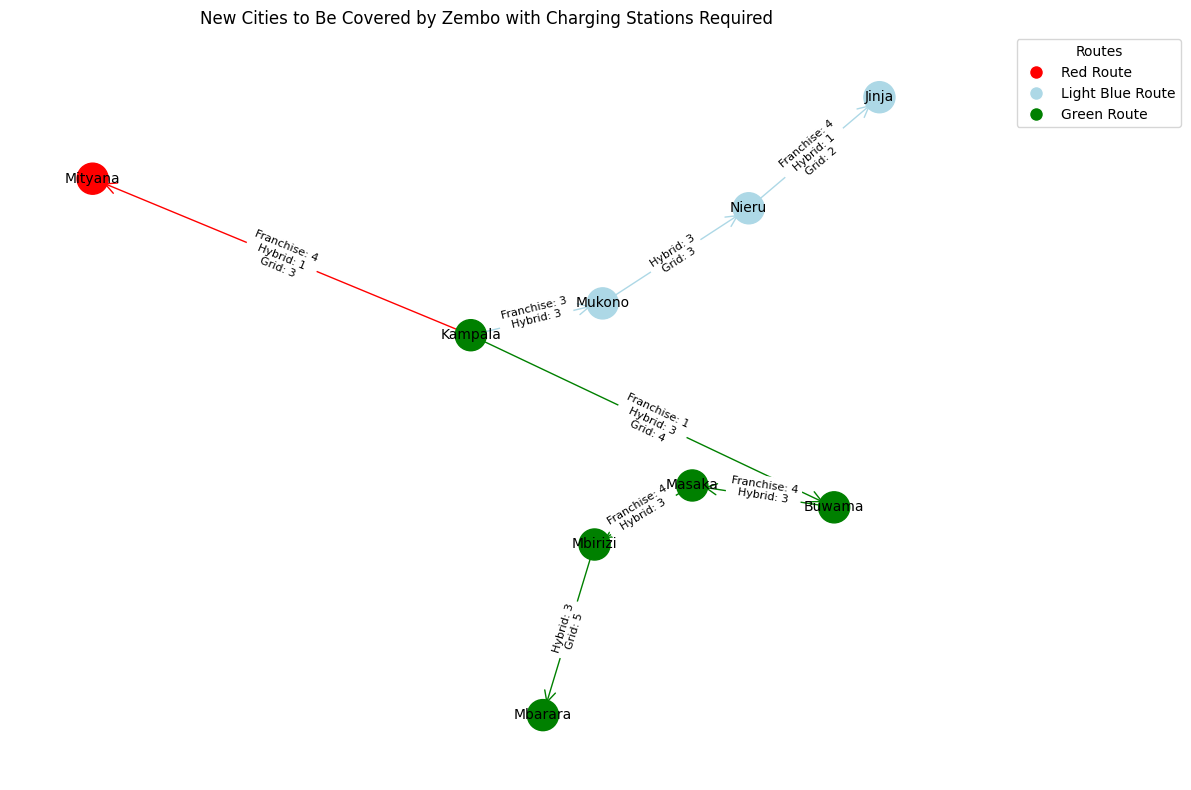

In [3]:
import math
import networkx as nx
import matplotlib.pyplot as plt

# Print details for each city
print("    The New cities to be covered by Zembo are:\n")
selected_cities = []
for i in range(Num_Cities):
    if x[i].x > 0.5:  # City is selected if x[i] > 0.5
        selected_cities.append(i)

# Define specific colors for routes
route_colors = {
    "red": "red",
    "lightblue": "lightblue",
    "green": "green"
}

# Map legend names
legend_names = {
    "red": "Red Route",
    "lightblue": "Light Blue Route",
    "green": "Green Route"
}

# Create a graph of the selected cities and routes
G = nx.DiGraph()

# Add nodes for the selected cities with colors based on Route_Color
node_colors = []
for i in selected_cities:
    route = Route_Color[i]
    city_name = City[i]
    G.add_node(city_name)

    node_colors.append(route_colors.get(route, "gray"))

# Prepare edge labels for charging stations
edge_labels = {}

# Add edges based on the 'Previous ID' field
for i in selected_cities:
    if not pd.isna(PreviousID[i]) and PreviousID[i] in id_to_index:
        prev_index = id_to_index[PreviousID[i]]
        if x[prev_index].x > 0.5:  # Add edge only if the previous city is also selected
            from_city = City[prev_index]
            to_city = City[i]
            G.add_edge(from_city, to_city)

            # Determine the type and number of charging stations between nodes
            num_franchise = y_franchise[i].x
            num_hybrid = y_hybrid[i].x
            num_grid = y_grid[i].x

            # Create a label with the station information
            label = ""
            if num_franchise > 0:
                label += f"Franchise: {int(num_franchise)}\n"
            if num_hybrid > 0:
                label += f"Hybrid: {int(num_hybrid)}\n"
            if num_grid > 0:
                label += f"Grid: {int(num_grid)}"

            edge_labels[(from_city, to_city)] = label

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.5, iterations=50)

# Draw nodes with colors based on Route_Color
nx.draw_networkx_nodes(G, pos, node_size=500, node_color=node_colors)

# Draw node labels
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

# Prepare edge colors based on route colors
edge_colors = []
for (u, v) in G.edges():
    try:
        idx = City.index(v)  # Get destination city's route color
        route = Route_Color[idx]
        edge_colors.append(route_colors.get(route, "gray"))
    except ValueError:
        edge_colors.append("gray")  # Default color for unmatched edges

# Draw edges with colors based on Route_Color
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=20, edge_color=edge_colors)

# Add edge labels for charging station information
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, label_pos=0.5)

# Create a legend for routes
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label=legend_names[route],
                          markerfacecolor=color, markersize=10)
                   for route, color in route_colors.items()]
plt.legend(handles=legend_elements, title='Routes', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('New Cities to Be Covered by Zembo with Charging Stations Required')
plt.axis('off')
plt.tight_layout()
plt.show()
